# Project: Write a data science blog post

## Business Understanding 

 My focus on this project was to use Seattle Airbnb data to understand;

1. Areas with most Airbnb properties and expensive areas in the city
2. Seasonal changes in price of listing
3. The factors that influence the listing price

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

#read csv files from machine
listings_df = pd.read_csv('Seattle.listings.csv')
calendar_df = pd.read_csv('Seattle.calendar.csv')
reviews_df = pd.read_csv('Seattle.reviews.csv')
listings_df.head(2

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


# Data Preparation

## Data cleaning and wrangling

In [2]:
# convert string to float on price related columns
def clean_price(col):
    '''
    INPUT
    col - The price related column needed to be converted to float datatype
    
    OUTPUT
    col - column with convtered values to float datatype
    '''
    col = col.apply(lambda x: float((x[1:].replace(',',''))) if type(x) != float else x)
    return col  

In [3]:
# remove the $ sign of related price columns
listings_df['price'] = clean_price(listings_df['price'])
listings_df['cleaning_fee'] = clean_price(listings_df['cleaning_fee'])
listings_df['weekly_price'] = clean_price(listings_df['weekly_price'])
listings_df['monthly_price'] = clean_price(listings_df['monthly_price'])

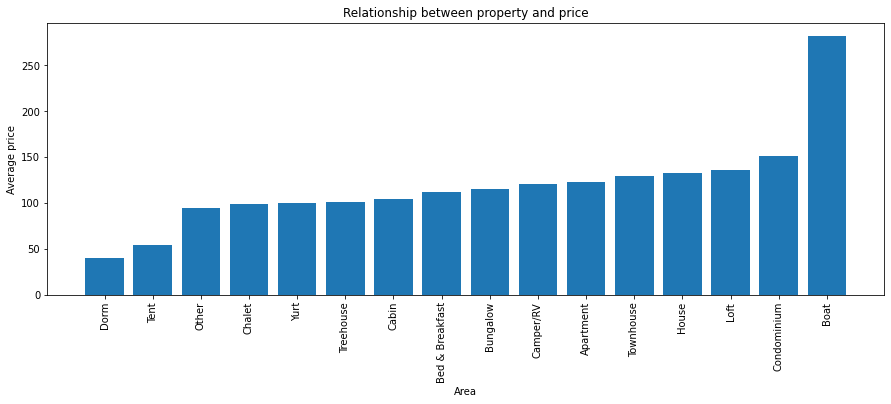

In [4]:
# Average of listing price in relation property type
prop_var = listings_df.groupby(listings_df['property_type'])['price'].mean().sort_values().reset_index()

# Plot the bar of relationship btween properties and listing prices
plt.figure(figsize = (15,5))
plt.bar(prop_var['property_type'], prop_var['price'])
plt.xlabel('Area')
plt.xticks(prop_var['property_type'], rotation = 90)
plt.ylabel('Average price')
plt.title('Relationship between property and price')
plt.show()

In [5]:
# Average of listing price in relation bedrooms
bedroom_var = listings_df.groupby(listings_df['bedrooms'])['price'].mean().reset_index()
bedroom_var

,bedrooms,price
0,0.0,103.548387
1,1.0,95.706247
2,2.0,174.062500
3,3.0,249.530035
4,4.0,313.695652
5,5.0,441.000000
6,6.0,578.166667
7,7.0,375.000000


In [6]:
# Average of listing price in relation street
zip_var = listings_df.groupby(listings_df['zipcode'])['price'].mean().sort_values().reset_index()
zip_var

,zipcode,price
0,99\n98122,67.000000
1,98106,82.103448
2,98108,83.875000
3,98133,86.282609
4,98125,88.577465
5,98118,93.798701
6,98178,94.428571
7,98146,97.800000
8,98177,98.842105
9,98144,105.395000


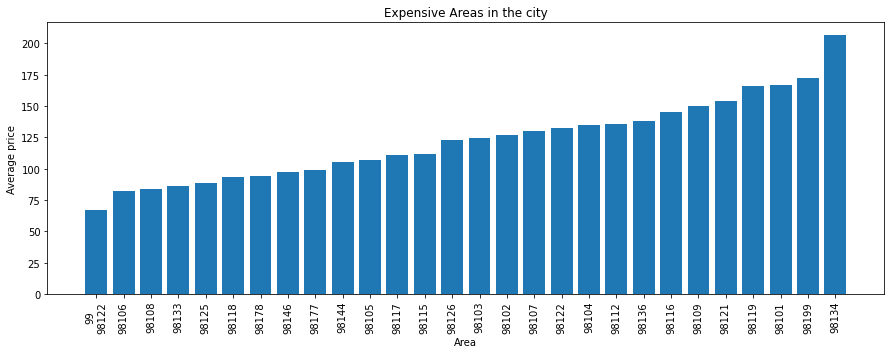

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize = (15,5))
plt.bar(zip_var['zipcode'], zip_var['price'])
plt.xlabel('Area')
plt.xticks(zip_var['zipcode'], rotation = 90)
plt.ylabel('Average price')
plt.title('Expensive Areas in the city')
plt.show()

# Question 1: Areas with most Airbnb properties and expensive areas in the city

From the plot graph, the expensive property types in the city are boat and condomonium and cheap properties are dorm and tent. Zipcode with 98123 and 98199 take lead in expensive areas in the city and cheap area with zipcode 98122

# Modelling 

## Price prediction

In [7]:
# Cleaning of the dataset

# Pick few important variables that influence the price to predict the listing price
df2 = listings_df[['beds','bedrooms','price',
                  'cleaning_fee','bathrooms','accommodates','reviews_per_month',
                  'weekly_price','monthly_price','instant_bookable','cancellation_policy']]
df2.head(5)

,beds,bedrooms,price,cleaning_fee,bathrooms,accommodates,reviews_per_month,weekly_price,monthly_price,instant_bookable,cancellation_policy
0,1.0,1.0,85.0,NaN,1.0,4,4.07,NaN,NaN,f,moderate
1,1.0,1.0,150.0,40.0,1.0,4,1.48,1000.0,3000.0,f,strict
2,7.0,5.0,975.0,300.0,4.5,11,1.15,NaN,NaN,f,strict
3,2.0,0.0,100.0,NaN,1.0,3,NaN,650.0,2300.0,f,flexible
4,3.0,3.0,450.0,125.0,2.0,6,0.89,NaN,NaN,f,strict


<AxesSubplot:>

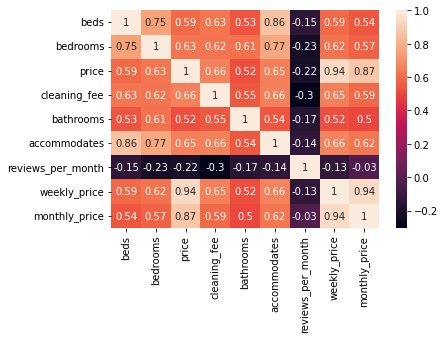

In [23]:
# show correlation amongs the features
sns.heatmap(df2.corr(), annot=True)

In [8]:
# fill the numeric columns with the mean
num_vars= df2.select_dtypes(include=['int','float']).columns
for col in num_vars:
    df2.loc[:,col] = df2[col].fillna(df2[col].mean())

/var/folders/yy/x3d2mrqx4zdc2sh5v1gfd0b80000gn/T/ipykernel_799/4013295059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,col] = df2[col].fillna(df2[col].mean())


In [9]:
# Dummy catagorical columns
cat_vars =df2.select_dtypes(include=['object','bool']).columns #list of categorical columns
for col in cat_vars:
    # for each catagorical col, dummy the var and drop original col
    df2= pd.concat([df2.drop(col, axis=1), pd.get_dummies(df2[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

In [10]:
# create the output and input variables for the model
X= df2.drop('price', axis=1)
y= df2['price']

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# define the model
lm_model = LinearRegression(normalize = True)

# fit the model with data
lm_model.fit(X_train, y_train)

# make a predict
y_test_predict = lm_model.predict(X_test)
y_train_predict = lm_model.predict(X_train)

# Evaluate the predicts
test_score = r2_score(y_test, y_test_predict)
train_score = r2_score(y_train, y_train_predict)

The test score >> 0.6106924826212423
The train score >> 0.6127076826643214
The r-squared score for the model is 0.6106924826212423 on 1146 values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [11]:
print(f"The test score >> {test_score}")
print(f"The train score >> {train_score}")

print(f"The r-squared score for the model is {test_score} on {len(y_test)} values")

The test score >> 0.6106924826212423
The train score >> 0.6127076826643214
The r-squared score for the model is 0.6106924826212423 on 1146 values


# Evaluations

In [42]:
# variable features impact on the price
coef_df = pd.DataFrame()
coef_df['Variable feature'] = X_train.columns
coef_df['coef'] = lm_model.coef_
coef_df['abs_coef'] = np.abs(lm_model.coef_)
coef_df = coef_df.sort_values(by=['abs_coef'], ascending=False)
print('Rank features by their impact on the price: \n', coef_df, '\n')

Rank features by their impact on the price: 
                 Variable feature       coef   abs_coef
3                      bathrooms  16.965889  16.965889
4                   accommodates  11.605794  11.605794
1                       bedrooms  10.722350  10.722350
5              reviews_per_month  -3.330174   3.330174
0                           beds  -2.768310   2.768310
9   cancellation_policy_moderate  -2.033063   2.033063
8             instant_bookable_t   2.009741   2.009741
10    cancellation_policy_strict   0.520683   0.520683
2                   cleaning_fee   0.393119   0.393119
6                   weekly_price   0.082866   0.082866
7                  monthly_price   0.001238   0.001238 



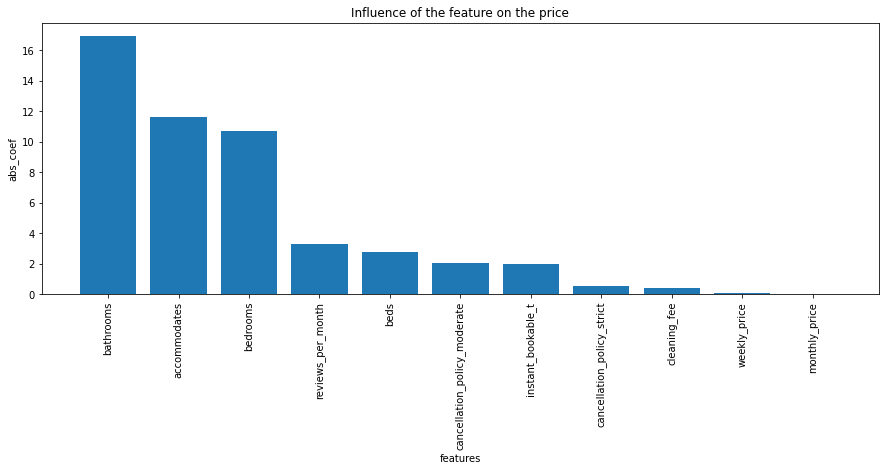

In [41]:
# plot influence of varible features on price
plt.figure(figsize = (15,5))
plt.bar(coef_df['Variable feature'], coef_df['abs_coef'])
plt.xlabel('features')
plt.xticks(coef_df['Variable feature'], rotation = 90)
plt.ylabel('abs_coef')
plt.title('Influence of the feature on the price')
plt.show()

# Question 3: The factors that influence the listing price

The impact of certain features like property type and zipcode can not excluded. In addition, bedrooms, accommodates and bathrooms show tremendous impact on the listing price